In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

In [310]:
def rectangular_grid(xcells, ycells, points_df):
    xmin = points_df['lon'].min()
    xmax = points_df['lon'].max()
    ymin = points_df['lat'].min()
    ymax = points_df['lat'].max()

    xwindow = (xmax-xmin)/xcells
    ywindow = (ymax-ymin)/ycells

    x0, y0 = xmin, ymax
    pols = []
    for w in range(ycells):
        for h in range(xcells):
            pols.append(shapely.geometry.Polygon([(x0,y0),(x0+xwindow,y0),(x0+xwindow,y0-ywindow),(x0,y0-ywindow)]))
            x0 += xwindow
        y0 -= ywindow
        x0 = xmin
    rg = gpd.GeoDataFrame(geometry=pols, crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))
    rg.index = rg.index.map(str)
    return rg 

def choropleth(grid, data, color_scale, location, zoom):
    f = folium.Figure(width=970, height=300)
    m = folium.Map(
        location=location,
        tiles='Stamen Terrain',
        zoom_start=zoom
    ).add_to(f)
    data.index = data.index.map(str) # bug prevention
    m.choropleth(geo_data=grid, 
                 data=data,
                 threshold_scale=color_scale,
                 key_on="feature.id",
                 fill_color='Spectral_r',line_weight=2)
    return m

def cscale(data):
    scale = []
    for i in [0,0.50,0.80,0.95,1]:
        if i==0:
            if data.quantile(i)==0:
                scale.append(0)
            else:
                scale.append(data.quantile(i)-1)
        else:
            scale.append(data.quantile(i)+1)
    return scale

def plot_mapvar(data, var, time):
    s = data.loc[var].reset_index()
    data = s.loc[s['Timestamp']==time].set_index('index_grid')['Value']

    return choropleth(grid=grid, 
               data=data, 
               color_scale=cscale(data), location=[55.00 ,-1.50], zoom=11)

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_allsensors_8days'

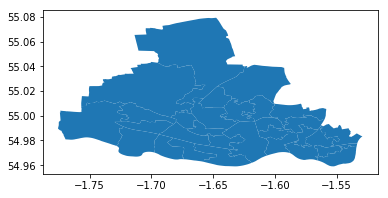

In [4]:
lsoa = gpd.read_file(SHAPE_FOLDER+'/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

lsoa.plot()

In [148]:
metadata = pd.read_csv(DATA_FOLDER+'/sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

metadata.shape

(260, 5)

In [150]:
sensors = pd.read_csv(DATA_FOLDER+'/data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='H'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

sensors.reset_index()['Sensor Name'].unique().shape

(260,)

In [151]:
# grid creation
xcells, ycells = 20, 20
grid = rectangular_grid(xcells, ycells, metadata)

# spatial join between sensors position and their grid cell
grid_hash = gpd.sjoin(metadata, grid, rsuffix='grid' ,op='intersects')['index_grid']

In [393]:
def knearestneighbors(metadata, sensors, grid, k): 
    result = pd.DataFrame(columns=['Variable','index_grid','Timestamp','Value'])
    c=0
    for var in sensors.index.get_level_values(0).unique():
        for i in grid.index:
            centroid = grid['geometry'][i].centroid

            res = pd.DataFrame()
            s = sensors.loc[var].reset_index()
            s['geometry'] = s.join(metadata, on='Sensor Name')['geometry']
            #
            for t in s['Timestamp'].unique():
                tmp = s.loc[s.loc[s['Timestamp']==t].apply(lambda x: x['geometry'].distance(centroid), axis=1).sort_values()[:k].index].groupby('Timestamp').median().reset_index()
                tmp['index_grid'] = i
                tmp['Variable'] = var
                result.loc[c] = tmp.loc[0]
                c+=1
        print(var, 'ok')
    return result.set_index(['Variable','index_grid','Timestamp'])

nn3 = knearestneighbors(metadata,sensors,grid,3)

CO ok
Humidity ok
Journey Time ok
NO2 ok
O3 ok
PM10 ok
Particle Count ok
Sound ok
Temperature ok
Wind Direction ok
Wind Speed ok


In [397]:
plot_mapvar(nn3, 'NO2', '2018-07-09 07:00:00')

In [394]:
nn3

Value
Variable   index_grid Timestamp                      
CO         0          2018-07-09 00:00:00  327.315860
                      2018-07-09 01:00:00  276.618084
                      2018-07-09 02:00:00  277.667236
                      2018-07-09 03:00:00  283.403511
                      2018-07-09 04:00:00  283.955729
                      2018-07-09 05:00:00  282.908794
                      2018-07-09 06:00:00  302.738334
                      2018-07-09 07:00:00  382.776063
                      2018-07-09 08:00:00  370.736310
                      2018-07-09 09:00:00  434.866510
           1          2018-07-09 00:00:00  327.315860
                      2018-07-09 01:00:00  276.618084
                      2018-07-09 02:00:00  277.667236
                      2018-07-09 03:00:00  283.403511
                      2018-07-09 04:00:00  283.955729
                      2018-07-09 05:00:00  282.908794
                      2018-07-09 06:00:00  302.738334
                      2018-07-09 07:00:00  382.776063
                      2018-07-09 08:00:00  370.736310
                      2018-07-09 09:00:00  434.866510
           2          2018-07-09 00:00:00  327.315860
                      2018-07-09 01:00:00  276.618084
                      2018-07-09 02:00:00  277.667236
                      2018-07-09 03:00:00  283.403511
                      2018-07-09 04:00:00  283.955729
                      2018-07-09 05:00:00  282.908794
                      2018-07-09 06:00:00  302.738334
                      2018-07-09 07:00:00  382.776063
                      2018-07-09 08:00:00  370.736310
                      2018-07-09 09:00:00  434.866510
...                                               ...
Wind Speed 397        2018-07-09 00:00:00    1.080000
                      2018-07-09 01:00:00    1.155000
                      2018-07-09 02:00:00    0.790000
                      2018-07-09 03:00:00    0.758712
                      2018-07-09 04:00:00    1.045000
                      2018-07-09 05:00:00    0.765000
                      2018-07-09 06:00:00    1.165000
                      2018-07-09 07:00:00    0.940000
                      2018-07-09 08:00:00    1.340000
                      2018-07-09 09:00:00    1.080000
           398        2018-07-09 00:00:00    1.080000
                      2018-07-09 01:00:00    1.155000
                      2018-07-09 02:00:00    0.790000
                      2018-07-09 03:00:00    0.758712
                      2018-07-09 04:00:00    1.045000
                      2018-07-09 05:00:00    0.765000
                      2018-07-09 06:00:00    1.165000
                      2018-07-09 07:00:00    0.940000
                      2018-07-09 08:00:00    1.340000
                      2018-07-09 09:00:00    1.080000
           399        2018-07-09 00:00:00    1.080000
                      2018-07-09 01:00:00    1.155000
                      2018-07-09 02:00:00    0.790000
                      2018-07-09 03:00:00    0.758712
                      2018-07-09 04:00:00    1.045000
                      2018-07-09 05:00:00    0.765000
                      2018-07-09 06:00:00    1.165000
                      2018-07-09 07:00:00    0.940000
                      2018-07-09 08:00:00    1.340000
                      2018-07-09 09:00:00    1.080000

[44000 rows x 1 columns]

In [ ]:
# def inverse_distance_weighting():